## Semantic Book Recommender - Data Preprocessing

**Purpose:**

This Jupyter notebook performs the data cleaning and preprocessing steps for building a semantic book recommender using the Kaggle 7k Books dataset. The dataset contains a collection of books with metadata such as title, author, description, rating, and categories. We'll be preparing the data so we can later use NLP techniques on it (using Python, OpenAI, LangChain, and Gradio).

Link to dataset: [https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata](https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata)

### 1. Downloading the Dataset
In this section, we download the Kaggle 7k Books dataset. If it's the first time you're running this notebook, the dataset will be downloaded. On subsequent runs, we’ll just use the already downloaded version.

In [1]:
# On first github download, run this cell to download data
# On re-runs, use the next cell

import kagglehub

# Download latest version (comment out if you already downloaded it)
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

# Use this variable if you already have downloaded data, replacing the path with your location
# path = r"C:\Users\bhabt\.cache\kagglehub\datasets\dylanjcastillo\7k-books-with-metadata\versions\3"

Path to dataset files: C:\Users\bhabt\.cache\kagglehub\datasets\dylanjcastillo\7k-books-with-metadata\versions\3


### 2. Load the Data
Here, we load the dataset into a Pandas DataFrame, which allows us to explore and analyze the dataset more easily.

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Load the dataset from the specified path
books = pd.read_csv(f"{path}/books.csv")

# Display the first few rows of the dataset
books.head()


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


### 3. Initial Data Exploration
We explore some basic characteristics of the dataset. We observe the unique values, missing data, and distribution across 
different columns like ISBN, subtitle, and categories.

We can notice the following by looking at the data column statistics using VS Code's Data Wrangler extension.

Observations:
- There are 6810 distinct values in the isbn13 column, which tells us each entry is unique.
- The subtitle column has 65% missing values, which makes it less useful for our analysis.
- The categories column has 567 categories, many of which are random and need to be cleaned.
- The description column is only missing for about 5% of books, so it's relatively complete.

The next step is to do a deeper investigation to make sure the missing information isn't biased.


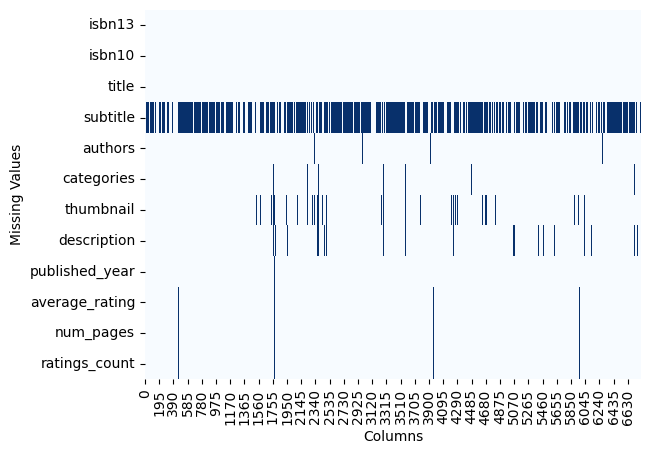

In [4]:
# Heatmap to visualize missing data
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax, cmap='Blues')

plt.xlabel("Columns")
plt.ylabel("Missing Values")

plt.show()

#### Key Observations:
- Subtitle column has a high percentage of missing values.
- Categories, Thumbnails, and Descriptions have missing data randomly, suggesting that it may not introduce much bias.
- For the fields like average_rating, num_pages, and rating_count, rows with missing values in one of these fields tend to have missing values in the others too. This suggests they may come from different sources and introduces potential bias (perhaps they are newer or have different ratings).

### 4. Exploring Books with Missing Descriptions
Now, we focus on the books that have missing descriptions since this field will be a key feature in our natural language processing (NLP) work. We want to ensure that books with missing descriptions are handled properly and not cause skewing in our recommender.

In [5]:
import numpy as np

# Add a new column to flag missing descriptions
books["missing_description"] = np.where(books["description"].isna(), 1, 0)

# Add a new column to calculate the age of the book
books["age_of_book"] = 2025 - books["published_year"]

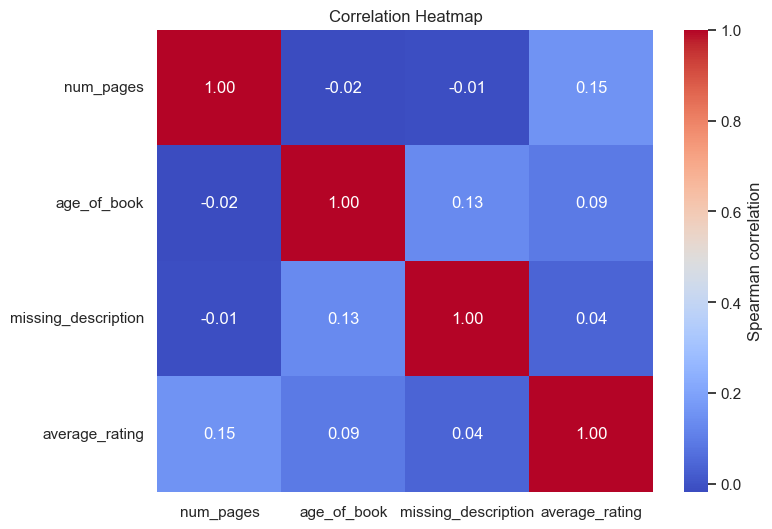

In [6]:
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]

# Compute Spearman correlation matrix for these columns
# Note: Pearson correlations are more appropriate when dealing with completely continuous variables, ours is binary
correlation_matrix = books[columns_of_interest].corr(method = "spearman")

# Visualize the correlation matrix
sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label" : "Spearman correlation"})
heatmap.set_title("Correlation Heatmap")
plt.show()

#### Key Observations:
- We check correlations for missing descriptions. Eg. if correlations with other variables like num_pages were strong, we might need to consider removing certain books from our analysis to avoid favoring longer or shorter books.
- In this case, the correlations aren't strong, so we have more confidence that the remaining data is fairly representative. The books we are left with will have a pretty good range of ratings and lengths.

In a future project, we could try webscraping to fill in the date. For now, since there doesn't seem to be a pattern in terms of missingness, it's safe for us to delete those observations with missing values.

### 5. Investigating Missing Data
Next, we check how many books will be removed if we drop rows with missing values in essential fields like description, pages, rating, and published year.

In the following cell, we see that dropping books with missing descriptions and essential metadata leaves us with 303 rows. This represents less than 5% of the dataset, so it's acceptable to drop these rows.

In [7]:
books[(books["description"].isna()) |
      (books["num_pages"].isna()) |
      (books["average_rating"].isna()) |
      (books["published_year"].isna())
      ]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,1,25.0
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,1,23.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,1,47.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,1,72.0
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,1,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,1,23.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,1,19.0
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,0,18.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,1,32.0


### 6. Final Cleaning of Data
After cleaning, we filter out the rows that don’t meet our criteria, keeping only the books with valid descriptions and metadata. We also create a new column that combines the title and subtitle of books where applicable.

In [8]:
# Filter out rows with missing values in description, num_pages, average_rating, or published_year

book_missing = books[~(books["description"].isna()) &
      ~(books["num_pages"].isna()) &
      ~(books["average_rating"].isna()) &
      ~(books["published_year"].isna())
      ]

# Taking a closer look at category distribution after filtering
book_missing["categories"].value_counts().reset_index().sort_values("count", ascending=False)


,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
280,Butlers,1
279,Gardens,1
278,Assassins,1
277,Married people,1


### 7. Words in Description
Here, we inspect the word count of book descriptions to ensure that descriptions are meaningful for building a semantic recommender. We look for books with very short descriptions, as these won’t provide enough context for recommendation.

We have a pretty good distribution of the number of words in the description from around 10 words to 200-300. There's not a clear breakpoint for how long a description needs to be so it's meaningful. So we will create out own arbitrary cutoff.

In [9]:
# We can immediately see in row 6 a book with the description that says "Donation." 
# And on row 11, we only have "Fantasy-roman." This short won't be useful.
book_missing.head(15)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0
6,9780006353287,0006353282,An Autobiography,NaN,Agatha Christie,"Authors, English",http://books.google.com/books/content?id=c49GQ...,Donation.,1977.0,4.27,560.0,3975.0,0,48.0
7,9780006380832,0006380832,Empires of the Monsoon,A History of the Indian Ocean and Its Invaders,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,0,27.0
8,9780006470229,000647022X,The Gap Into Madness,Chaos and Order,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0,0,31.0
9,9780006472612,0006472613,Master of the Game,NaN,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,0,43.0


In [10]:
# The easiest way to categorize these is by checking description lengths

book_missing["words_in_description"] = book_missing["description"].str.split().str.len()

# Filter and inspect descriptions based on word count
book_missing.loc[book_missing["words_in_description"].between(1, 4), "description"].head(15)

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
Name: description, dtype: object

Books with very short descriptions (1-4 words) don’t provide much meaningful information. We'll filter these out. Through playing around with the count value, we can see that around 25 words is a good cutoff point.

In [11]:
pd.set_option('display.max_colwidth', 100)

book_missing.loc[book_missing["words_in_description"].between(25,34), "description"].head(15)

9      Kate Blackwell is an enigma and one of the most powerful women in the world. But at her ninetiet...
14     Available in the U.S. for the first time, this is the second volume in the exceptional Legends o...
20     It is 1937, and Charles Ashworth, a Canon to the Archbishop of Canterbury, is sent to untangle a...
21     Reissue of the author's most famous and well-loved work, the Starbridge series, six self-contain...
46     No one believes a little girl when she insists that she has witnessed a murder until she herself...
66     When a dangerous necromancer threatens to unleash a long-buried evil, Lirael and Prince Sameth a...
71     It should be the most natural thing in the world. But in Tony Parsons' latest bestseller, three ...
78     From bang-ups and hang-ups to lurches and slumps. Dr. Seuss takes a hilarious look at the mishap...
103    The only style manual ever to appear on the best-seller lists offers practical, fundamental advi...
107    A Swedish boy long ago accompa

In [12]:
pd.set_option('display.max_colwidth', 50)

### 8. Final Cleanup
In this step, we filter the books to retain only those with descriptions longer than 25 words and combine titles and subtitles for books where applicable. We also tag descriptions with unique identifiers.

In [15]:
# Filter books that have at least 25 words in their description
book_missing_25_words = book_missing[book_missing["words_in_description"] >= 25]

book_missing_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174


We lose 5197 books, but realistically we wouldn't have been able to use them anyway unless we replaced the descriptions.

In [16]:
# Combine title and subtitle where applicable
book_missing_25_words["title_and_subtitle"] = (
    np.where(book_missing_25_words["subtitle"].isna(), book_missing_25_words["title"],
             book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)

# Create a unique tag for each description to use in vector database using isbn
book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)

# Drop unnecessary columns
book_missing_25_words.drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1).to_csv("books_cleaned.csv", index=False)


### Conclusion
We’ve successfully cleaned and preprocessed the 7k Books dataset, preparing it for use in NLP tasks for building the semantic book recommender. The final cleaned dataset is saved as books_cleaned.csv, which will be used in the next stages of the project.